In [5]:
import os
import sys
import argparse
import base64
import io
import time
import glob
import re
import torch
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModelForVision2Seq
from peft import PeftConfig, PeftModel

/home/daniel/miniconda3/envs/vlm-navigation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:

def load_vamos_model(model_name_or_path, use_fp32=False, trust_remote_code=True):
    """
    Load the VAMOS model and processor from Hugging Face.
    
    Args:
        model_name_or_path: Hugging Face model name or local path
        use_fp32: Use FP32 precision instead of bfloat16
        trust_remote_code: Trust remote code for model loading
    
    Returns:
        tuple: (model, processor, device) or (None, None, None) if failed
    """
    print(f"🔄 Loading VAMOS model from: {model_name_or_path}")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🖥️  Using device: {device}")
    
    try:
        if "lora" in model_name_or_path.lower():
            print("📦 Loading LoRA model...")
            peft_config = PeftConfig.from_pretrained(model_name_or_path)
            base_model_name = peft_config.base_model_name_or_path
            
            # Load processor from base model
            processor = AutoProcessor.from_pretrained(
                base_model_name,
                trust_remote_code=trust_remote_code
            )
            
            # Load base model first
            model = AutoModelForVision2Seq.from_pretrained(
                base_model_name,
                torch_dtype=torch.float32 if use_fp32 else torch.bfloat16,
                trust_remote_code=trust_remote_code
            ).to(device)
            
            # Then load LoRA adapter
            model = PeftModel.from_pretrained(model, model_name_or_path)
            
            print("✅ LoRA model loaded successfully!")
            return model, processor, device
        else:
            print("📦 Loading standard model...")
            # Load regular model
            processor = AutoProcessor.from_pretrained(
                model_name_or_path,
                trust_remote_code=trust_remote_code
            )
            
            model = AutoModelForVision2Seq.from_pretrained(
                model_name_or_path,
                torch_dtype=torch.float32 if use_fp32 else torch.bfloat16,
                trust_remote_code=trust_remote_code
            ).to(device)
            
            print("✅ Model loaded successfully!")
            return model, processor, device
            
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None, None

def decode_trajectory_string(trajectory_string, img_height, img_width, expected_tokens=10):
    """Convert a string of location tokens into a list of coordinates."""
    # Use regex to find all <loc> tokens
    generated_traj = trajectory_string.split("\n")[-1]
    tokens = re.findall(r'<loc\d{4}>', generated_traj)
    
    if len(tokens) < 2:
        return torch.empty((0, 2), dtype=torch.float32)
    
    # Convert tokens to coordinates
    coords = []
    for token in tokens:
        num = int(token[4:8])
        coords.append(num)

    # Padding logic
    if len(coords) < expected_tokens:
        if len(coords) % 2 != 0:
            coords = coords[:-1]
            
        if len(coords) >= 2:
            last_pair = coords[-2:]
            while len(coords) < expected_tokens:
                coords.extend(last_pair)
        elif len(coords) == 0:
             return torch.empty((0, 2), dtype=torch.float32)

    if not coords:
        return torch.empty((0, 2), dtype=torch.float32)

    coords_tensor = torch.tensor(coords).reshape(-1, 2).float()
    
    # Normalize coordinates back to image space
    if img_width > 0:
        coords_tensor[:, 0] = coords_tensor[:, 0] * img_width / 1024
    else:
         coords_tensor[:, 0] = 0
    if img_height > 0:
        coords_tensor[:, 1] = coords_tensor[:, 1] * img_height / 1024
    else:
         coords_tensor[:, 1] = 0
    
    return coords_tensor

def generate_trajectories(model, processor, image, text_prompt, max_tokens=10, temperature=0.1, 
                         top_k=0, num_beams=1, num_samples=3, device="cpu"):
    """
    Generate trajectories using the loaded model.
    
    Args:
        model: Loaded VLM model
        processor: Loaded processor
        image: PIL Image object
        text_prompt: Navigation prompt
        max_tokens: Maximum tokens to generate
        temperature: Sampling temperature
        top_k: Top-k sampling parameter
        num_beams: Number of beams for beam search
        num_samples: Number of samples to generate
        device: Device to run inference on
    
    Returns:
        tuple: (trajectories, generated_texts, error_message)
    """
    try:
        print(f"🧠 Generating trajectories with prompt: '{text_prompt}'")
        
        # Prepare model input
        model_input = processor(
            text=["<image><bos>" + text_prompt],
            images=[image.convert("RGB")],
            return_tensors="pt",
            padding="longest",
        ).to(device)
        
        # Generation parameters
        generation_kwargs = {
            "max_new_tokens": max_tokens,
            "do_sample": (temperature > 0),
            "num_return_sequences": num_samples
        }
        
        if temperature > 0:
            generation_kwargs["temperature"] = temperature
        if top_k > 0:
            generation_kwargs["top_k"] = top_k
        if num_beams > 1:
            generation_kwargs["num_beams"] = num_beams
        
        # Generate trajectories
        with torch.no_grad():
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            outputs = model.generate(**model_input, **generation_kwargs)
        
        # Decode output sequences
        generated_texts = processor.batch_decode(outputs, skip_special_tokens=True)
        
        all_pred_coords = []
        valid_generated_texts = []
        
        # Process each generated sequence
        for text in generated_texts:
            try:
                pred_coords = decode_trajectory_string(
                    text, 
                    image.size[1],  # height
                    image.size[0],  # width
                    expected_tokens=max_tokens
                )
                if pred_coords.numel() > 0:
                    all_pred_coords.append(pred_coords.tolist())
                    valid_generated_texts.append(text)
            except Exception as e:
                print(f"⚠️  Error decoding trajectory: {e} for text: {text}")
        
        return all_pred_coords, valid_generated_texts, None
        
    except Exception as e:
        error_message = f"Error during model generation: {str(e)}"
        print(f"❌ {error_message}")
        return [], [], error_message


def visualize_results(image, trajectories, text_prompt):
    """
    Visualize the navigation results.
    
    Args:
        image: PIL Image object
        trajectories: List of trajectory coordinates
        text_prompt: Original text prompt
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original image
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Image with trajectories
    ax2.imshow(image)
    
    if trajectories and len(trajectories) > 0:
        colors = plt.cm.tab10(np.linspace(0, 1, len(trajectories)))
        
        for i, trajectory in enumerate(trajectories):
            if len(trajectory) > 0:
                traj_array = np.array(trajectory)
                if traj_array.shape[1] >= 2:
                    x_coords = traj_array[:, 0]
                    y_coords = traj_array[:, 1]
                    
                    # Plot trajectory
                    ax2.plot(x_coords, y_coords, 'o-', color=colors[i], 
                           linewidth=2, markersize=4, alpha=0.8, 
                           label=f'Trajectory {i+1}')
                    
                    # Mark start and end points
                    ax2.plot(x_coords[0], y_coords[0], 'go', markersize=8, label='Start' if i == 0 else "")
                    ax2.plot(x_coords[-1], y_coords[-1], 'ro', markersize=8, label='End' if i == 0 else "")
    
    ax2.set_title(f'Navigation Results\nPrompt: "{text_prompt}"')
    ax2.axis('off')
    
    if trajectories and len(trajectories) > 0:
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print trajectory details
    print("\n📍 Trajectory Details:")
    for i, trajectory in enumerate(trajectories):
        if len(trajectory) > 0:
            traj_array = np.array(trajectory)
            if traj_array.shape[1] >= 2:
                # Calculate trajectory length
                distances = np.sqrt(np.diff(traj_array[:, 0])**2 + np.diff(traj_array[:, 1])**2)
                total_length = np.sum(distances)
                
                print(f"  Trajectory {i+1}: {len(trajectory)} waypoints, length: {total_length:.1f} pixels")
                print(f"    Start: ({traj_array[0, 0]:.1f}, {traj_array[0, 1]:.1f})")
                print(f"    End: ({traj_array[-1, 0]:.1f}, {traj_array[-1, 1]:.1f})")

In [ ]:
model, processor, device = load_vamos_model("mateoguaman/vamos", use_fp32=False)

🔄 Loading VAMOS model from: mateoguaman/paligemma2-3b-pt-224-sft-lora-vamos_10pct_gpt5_mini_cocoqa_localized_narratives_fixed
🖥️  Using device: cuda
📦 Loading LoRA model...


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 14513.16it/s]
/home/daniel/miniconda3/envs/vlm-navigation/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 19.07it/s]


✅ LoRA model loaded successfully!


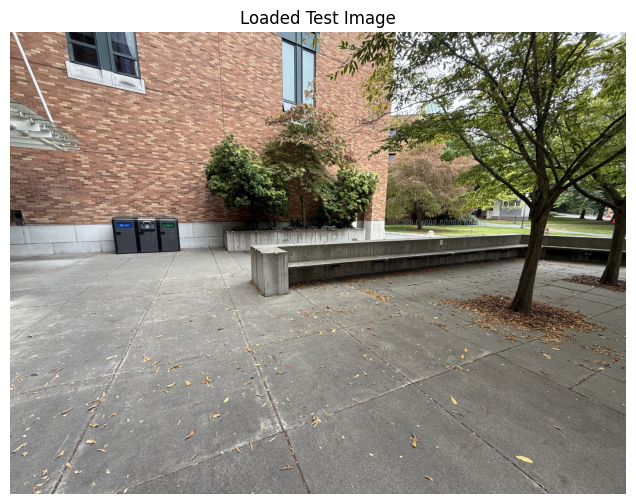

In [10]:
# Load an image from test_images directory
image_path = "test_images/tree.jpg"
image = Image.open(image_path).convert("RGB")

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title("Loaded Test Image")
plt.axis('off')
plt.show()



In [15]:
#Define parameters and text prompt
text_prompt = "Navigate to x=<loc0754>, y=<loc0519>"
temperature = 0.05
num_samples = 10

🔄 Running inference...
🧠 Generating trajectories with prompt: 'Navigate to x=<loc0754>, y=<loc0519>'
✅ Prediction successful!
⏱️  Processing time: 0.43s
🎯 Generated 10 trajectories
📄 Generated text 1: Navigate to x=<loc0754>, y=<loc0519>
<loc0660><loc0679><loc0696><loc0593><loc0716><loc0548><loc0728><loc0527><loc0754><loc0519>
📄 Generated text 2: Navigate to x=<loc0754>, y=<loc0519>
<loc0680><loc0685><loc0712><loc0603><loc0730><loc0558><loc0747><loc0537><loc0754><loc0519>
📄 Generated text 3: Navigate to x=<loc0754>, y=<loc0519>
<loc0616><loc0668><loc0680><loc0588><loc0720><loc0548><loc0747><loc0531><loc0754><loc0519>
📄 Generated text 4: Navigate to x=<loc0754>, y=<loc0519>
<loc0629><loc0688><loc0680><loc0603><loc0716><loc0558><loc0741><loc0531><loc0754><loc0519>
📄 Generated text 5: Navigate to x=<loc0754>, y=<loc0519>
<loc0675><loc0681><loc0712><loc0603><loc0727><loc0558><loc0747><loc0537><loc0754><loc0519>
📄 Generated text 6: Navigate to x=<loc0754>, y=<loc0519>
<loc0660><loc0688><loc

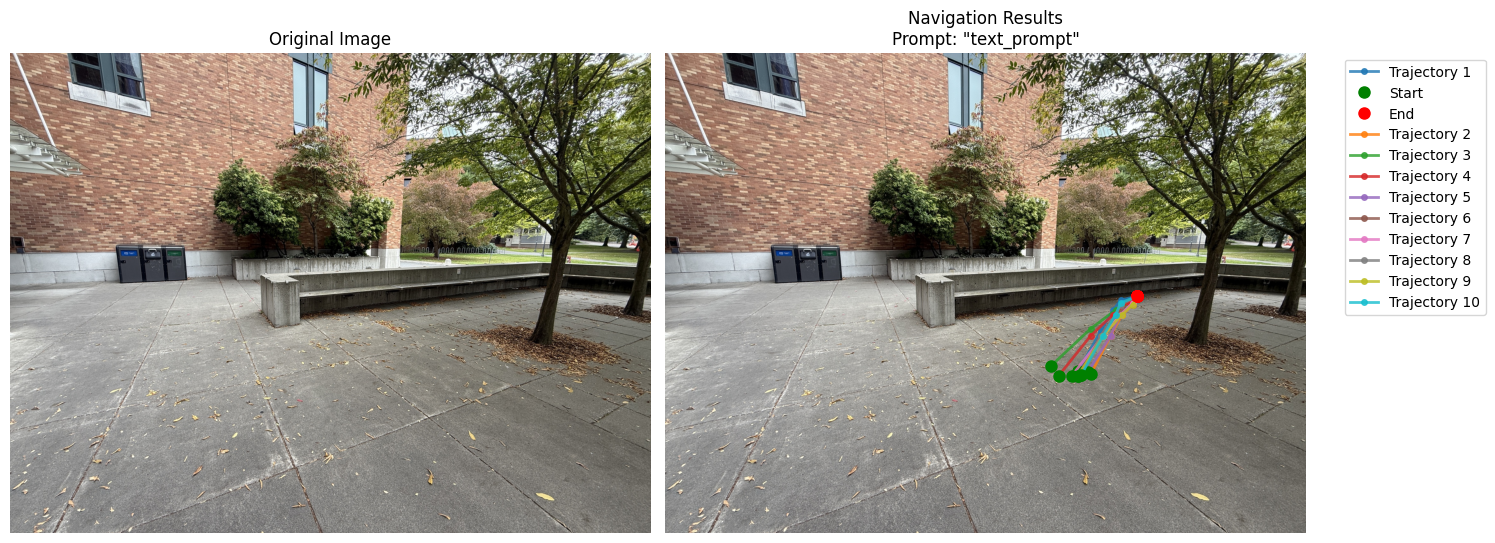


📍 Trajectory Details:
  Trajectory 1: 5 waypoints, length: 314.2 pixels
    Start: (1299.4, 1002.6)
    End: (1484.4, 766.3)
  Trajectory 2: 5 waypoints, length: 287.4 pixels
    Start: (1338.8, 1011.4)
    End: (1484.4, 766.3)
  Trajectory 3: 5 waypoints, length: 352.4 pixels
    Start: (1212.8, 986.3)
    End: (1484.4, 766.3)
  Trajectory 4: 5 waypoints, length: 352.3 pixels
    Start: (1238.3, 1015.9)
    End: (1484.4, 766.3)
  Trajectory 5: 5 waypoints, length: 289.0 pixels
    Start: (1328.9, 1005.5)
    End: (1484.4, 766.3)
  Trajectory 6: 5 waypoints, length: 317.1 pixels
    Start: (1299.4, 1015.9)
    End: (1484.4, 766.3)
  Trajectory 7: 5 waypoints, length: 323.2 pixels
    Start: (1279.7, 1015.9)
    End: (1484.4, 766.3)
  Trajectory 8: 5 waypoints, length: 310.9 pixels
    Start: (1309.2, 1012.9)
    End: (1484.4, 766.3)
  Trajectory 9: 5 waypoints, length: 312.6 pixels
    Start: (1299.4, 1015.9)
    End: (1484.4, 766.3)
  Trajectory 10: 5 waypoints, length: 313.2 pixels


In [16]:

print("🔄 Running inference...")

# Generate trajectories using the loaded model
start_time = time.time()
trajectories, generated_texts, error = generate_trajectories(
    model, processor, image, text_prompt, 
    temperature=temperature, 
    num_samples=num_samples, device=device
)
processing_time = time.time() - start_time

if error:
    print(f"❌ Prediction failed: {error}")

if trajectories and len(trajectories) > 0:
    print(f"✅ Prediction successful!")
    print(f"⏱️  Processing time: {processing_time:.2f}s")
    print(f"🎯 Generated {len(trajectories)} trajectories")
    
    # Print generated texts
    for i, text in enumerate(generated_texts):
        print(f"📄 Generated text {i+1}: {text}")
    
    # Visualize results
    visualize_results(image, trajectories, "text_prompt")
    
else:
    print("❌ No valid trajectories generated")